# Lab 4: Hidden Markov Models (HMMs)

<center><img src="https://github.com/ZKBig/8803_GMM_Lab3/blob/main/hmm_diagram.png?raw=true" width="430" height="200"/></center>
<!-- ![CA1_data](https://drive.google.com/uc?id=1y3QhKffqte7DbZmmXJFt2VC4zjbwrLGD) -->
<center> Figure 1: Graphical model for a hidden Markov model. The hidden state variables $ z_1, \ldots, z_N $ follow a Markov process, while each observation $ x_n $ is conditionally independent from other data given its associated hidden state variable $ z_n $.
. </center>

In this lab, we will implement forward-backward algorithm for HMMs and autoregressive HMMs to analyze the dataset concerning [depth videos of freely behaving mice](https://www.sciencedirect.com/science/article/pii/S0896627315010375?ref=pdf_download&fr=RR-2&rr=8cf1e56af9d6bfdd).

In [1]:
using_colab = False

In [2]:
if using_colab:
    import sys
    from google.colab import drive
    drive.mount('/content/gdrive/')
    sys.path.append('/content/gdrive/MyDrive/Lab4/')

In [3]:
# %%capture
# !pip install pynwb
# !pip install dynamax

In [3]:
# First, import necessary libraries.
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from tqdm.auto import trange
from pynwb import NWBHDF5IO
from utils import play, plot_data_and_states, nearest_positive_definite, sticky_transitions, random_args, initialize_posteriors, plot_average_pcs, make_crowd_movie
import torch
from tqdm import trange
from torch.distributions import MultivariateNormal, Normal

# Specify that we want our tensors on the GPU and in float32
device = torch.device('cpu')
dtype = torch.float32

# Helper functions to convert between numpy arrays and tensors
to_t = lambda array: torch.tensor(array, device=device, dtype=dtype)
from_t = lambda tensor: tensor.to("cpu").detach().numpy().astype(np.float64)

# 1. Introduction to the Dataset

This 3D pose dynamics of mice ([The depth videos of freely behaving mice](https://www.sciencedirect.com/science/article/pii/S0896627315010375?ref=pdf_download&fr=RR-2&rr=8cf1e56af9d6bfdd)) were recorded using a single depth camera positioned above the arena. Following image extraction, corrections were applied to address parallax-induced artifacts, and the mouse was subsequently centered and aligned along its inferred spinal axis. This preprocessing enabled a detailed quantification of pose changes over time. The mouse imaged in the circular open field with a standard RGB (left) and 2D depth camera (right) is shown in Figure 2.

<center><img src="https://github.com/ZKBig/8803_GMM_Lab3/blob/main/scenario.png?raw=true" width="430" height="200"/></center>
<!-- ![CA1_data](https://drive.google.com/uc?id=1y3QhKffqte7DbZmmXJFt2VC4zjbwrLGD) -->
<center> Figure 2: Mouse imaged in the circular open field with a standard RGB (left) and 3D depth camera (right, mm = mm above floor). Arrow indicates the inferred axis of the animal’s spine.
. </center>

Plotting these 3D data over time showed that mouse behavior consists of periods with slowly evolving pose dynamics, interrupted by rapid transitions that separate these intervals. This pattern seems to segment the behavioral imaging data into blocks usually lasting between 200 and 900 ms. For example, this temporal structure is evident in the raw imaging pixels (Figure 3, top) and the inferred shape of the mouse’s spine (Figure 3, bottom).

<center><img src="https://github.com/ZKBig/8803_GMM_Lab3/blob/main/observation1.png?raw=true" width="4600" height="200"/></center>
<!-- ![CA1_data](https://drive.google.com/uc?id=1y3QhKffqte7DbZmmXJFt2VC4zjbwrLGD) -->
<center> Figure 3: Raw pixels of the extracted and aligned 3D mouse image (top panel, sorted by mean height), and height at each inferred position of the mouse’s spine (bottom panel, "spine" data extracted from the mouse as indicated on the right, mm = mm above floor) each reveal sporadic, sharp transitions in the pose data over time.
. </center>

The temporal structure observed in the pose dynamics data suggests a timescale at which continuous behavior can be naturally segmented into meaningful components. Visual inspection of 3D movies indicates that each sub-second block of behavior corresponds to a distinct action (e.g., a dart, a pause, the initial phase of a rear). To investigate whether these sub-second actions are stereotyped, the 3D imaging data of the mouse was processed using wavelet decomposition followed by principal component analysis (PCA). This approach transformed each block of pose dynamics into a continuous trajectory within principal component (PC) space.

Now that we have covered the basic information about this 3D pose dynamics dataset of mice, let's deepen our understanding by working with it directly. Moreover, please feel free to refer to the paper [Mapping Sub-Second Structure in Mouse Behavior](https://www.sciencedirect.com/science/article/pii/S0896627315010375?ref=pdf_download&fr=RR-2&rr=8cf1e56af9d6bfdd) for more detailed preprocessing operations.

### 1.1 Neurodata Without Borders (NWB) format

NWB files are a structured form of HDF5 files. Like HDF5, NWBs are organized hierarchically into Groups and Datasets. However, NWBs differ in that they enforce a strict organization and labeling scheme to ensure uniformity across different labs.

The primary organizational components of NWBs are acquisitions and processing modules. Acquisitions represent raw data streams or references to them, while processing modules consist of analyzed data derived from these acquisitions.

MoSeq acquisitions contain complex and noisy Kinect video recordings that undergo processing to generate cleaned, egocentrically aligned frames, which are what you'll be working with. Since you don't need to handle preprocessing, the acquisition folder is empty, and all relevant data will be found in the MoSeq processing module.

Within processing modules, there are collections called “BehavioralTimeSeries,” which contain related behavioral data time series. Inside each “BehavioralTimeSeries,” you will find “TimeSeries,” which are individual datasets representing different time series.

The processing module is organized as such:

- MoSeq Processing Module (top level for all MoSeq processed data)
  - MoSeq Scalar Time Series (Behavioral time series dictionary for all MoSeq derived scalar time series)
    - angle
    - area
    - etc.
  - MoSeq Image Series (Behavioral time series dictionary for all MoSeq derived image time series)
    - frames
    - masks
  - MoSeq PC Series (Behavioral time series dictionary for all MoSeq derived PC time series)
    - principal components (with nans inserted for dropped frames)
    - principal components cleaned (with no nans)
  - MoSeq Label Series (Behavioral time series dictionary for all MoSeq derived lables)
    - labels (see above about dropped frames)
    - labels cleaned (see above)

### 1.2 Load and Read in an NWB file

In [5]:
%%capture
!wget -nc https://www.dropbox.com/s/564wzasu1w7iogh/moseq_data.zip
!unzip -n moseq_data.zip

In [4]:
nwb_path = 'data/saline_example_0.nwb'
io = NWBHDF5IO(nwb_path, mode='r')
nwbfile = io.read()

/Users/JosephYu/opt/anaconda3/envs/nbd_env/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.2.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/JosephYu/opt/anaconda3/envs/nbd_env/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [5]:
# Print the contents of the processing module
nwbfile.processing['MoSeq']

MoSeq pynwb.base.ProcessingModule at 0x6455493200
Fields:
  data_interfaces: {
    Images <class 'pynwb.behavior.BehavioralTimeSeries'>,
    Labels <class 'pynwb.behavior.BehavioralTimeSeries'>,
    PCs <class 'pynwb.behavior.BehavioralTimeSeries'>,
    Scalars <class 'pynwb.behavior.BehavioralTimeSeries'>
  }
  description: all MoSeq derived data

In [6]:
# Print the contents of one BehavioralTimeSeries
nwbfile.processing['MoSeq']['Images']

Images pynwb.behavior.BehavioralTimeSeries at 0x6455494064
Fields:
  time_series: {
    frames <class 'pynwb.image.ImageSeries'>,
    frames_masks <class 'pynwb.image.ImageMaskSeries'>
  }

In [7]:
# Examine the 'frames' time series
# One thing you'll notice is that the "timestamps" is actually another time series
# This is to save storage space when many time series share the same time stamps
nwbfile.processing['MoSeq']['Images']['frames']

frames pynwb.image.ImageSeries at 0x6455494640
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (35964, 80, 80), type "|u1">
  description: no description
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: angle pynwb.base.TimeSeries at 0x6455495072
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (35964,), type "<f4">
  description: no description
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamp_link: (
    frames <class 'pynwb.image.ImageSeries'>,
    frames_masks <class 'pynwb.image.ImageMaskSeries'>,
    labels_clean <class 'pynwb.base.TimeSeries'>,
    pcs_clean <class 'pynwb.base.TimeSeries'>,
    area_mm <class 'pynwb.base.TimeSeries'>,
    area_px <class 'pynwb.base.TimeSeries'>,
    centroid_x_mm <class 'pynwb.base.TimeSeries'>,
    centroid_x_px <class 'pynwb.base.TimeSeries'>,
    centroid_y_mm <class 'pynwb.base.TimeSeries'>,
    centroid_y_px <class 'pynwb.base.TimeSeries'>,
    height_ave_mm <class 'pynwb.base.TimeSeries'>,
    length_mm <class 'pynwb.base.TimeSeries'>,
    length_px <class 'pynwb.base.TimeSeries'>,
    velocity_2d_mm <class 'pynwb.base.TimeSeries'>,
    velocity_2d_px <class 'pynwb.base.TimeSeries'>,
    velocity_3d_mm <class 'pynwb.base.TimeSeries'>,
    velocity_3d_px <class 'pynwb.base.TimeSeries'>,
    velocity_theta <class 'pynwb.base.TimeSeries'>,
    width_mm <class 'pynwb.base.TimeSeries'>,
    width_px <class 'pynwb.base.TimeSeries'>
  )
  timestamps: <HDF5 dataset "timestamps": shape (35964,), type "<f8">
  timestamps_unit: seconds
  unit: theta

  timestamps_unit: seconds
  unit: mm

### 1.3 Load the video frames

In [8]:
# Since NWBs are backed with HDF5, you can do typical lazy/partial loading here
# Like hdf5s, you'll need to slice with [:] to get the array.
frames = nwbfile.processing['MoSeq']['Images']['frames'].data[:]
# Make sure to close the file when you're done!
io.close()
# Play a movie of the first 30 sec of data
play(frames[:900])

Preparing animation. This may take a minute...


### 1.4 Load all the mice into memory

The frames, even after cropping, are still 80x80 pixels. That’s a 3600 dimensional observation. In practice, the frames can be adequately reconstructed with far fewer principal components. As little as ten PCs does a pretty good job of capturing the mouse’s posture.

The Datta lab has already computed the principal components and included them in the NWB. We’ll extract them, along with other relevant information like the centroid position and heading angle of the mouse, which we’ll use for making “crowd” movies below. Finally, they also included labels from MoSeq, an autoregressive (AR) HMM. You'll also build an Gaussian HMM in Part 3 of the lab and infer similar discrete latent state sequences yourself!


In [9]:
def load_dataset(indices=None,
                 load_frames=True,
                 num_pcs=10):
    if indices is None:
        indices = np.arange(24)

    train_dataset = []
    test_dataset = []
    for t in trange(len(indices)):
        i = indices[t]
        nwb_path = "data/saline_example_{}.nwb".format(i)
        with NWBHDF5IO(nwb_path, mode='r') as io:
            f = io.read()
            num_frames = len(f.processing['MoSeq']['PCs']['pcs_clean'].data)
            train_slc = slice(0, int(0.8 * num_frames))
            test_slc = slice(int(0.8 * num_frames)+1, -1)

            train_data, test_data = dict(), dict()
            for slc, data in zip([train_slc, test_slc], [train_data, test_data]):
                data["raw_pcs"] = to_t(f.processing['MoSeq']['PCs']['pcs_clean'].data[slc][:, :num_pcs])
                data["times"] = to_t(f.processing['MoSeq']['PCs']['pcs_clean'].timestamps[slc][:])
                data["centroid_x_px"] = to_t(f.processing['MoSeq']['Scalars']['centroid_x_px'].data[slc][:])
                data["centroid_y_px"] = to_t(f.processing['MoSeq']['Scalars']['centroid_y_px'].data[slc][:])
                data["angles"] = to_t(f.processing['MoSeq']['Scalars']['angle'].data[slc][:])
                data["labels"] = to_t(f.processing['MoSeq']['Labels']['labels_clean'].data[slc][:])

            # only load the frames on the test data
            # test_data["frames"] = to_t(f.processing['MoSeq']['Images']['frames'].data[test_slc])
            test_data["frames"] = torch.tensor(f.processing['MoSeq']['Images']['frames'].data[test_slc])

        train_dataset.append(train_data)
        test_dataset.append(test_data)

    return train_dataset, test_dataset

# Load a third of the dataset (8 mice)
fps = 30
data_dim = 10
indices = np.arange(8)
train_dataset, test_dataset = load_dataset(num_pcs=data_dim, indices=indices)

  0%|          | 0/8 [00:00<?, ?it/s]/Users/JosephYu/opt/anaconda3/envs/nbd_env/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.2.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/JosephYu/opt/anaconda3/envs/nbd_env/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


### 1.5 Standardize the principal components

Standardize the principal components so that they are mean zero and unit variance. This will not affect the subsequent modeling, but it will make it easier for us to visualize the time series.

In [24]:
def standardize_pcs(dataset, mean=None, std=None):
    if mean is None and std is None:
        all_pcs = torch.vstack([data['raw_pcs'] for data in dataset])
        mean = all_pcs.mean(axis=0)
        std = all_pcs.std(axis=0)

    for data in dataset:
        data['data'] = (data['raw_pcs'] - mean) / std
    return dataset, mean, std

train_dataset, mean, std = standardize_pcs(train_dataset)
test_dataset, _, _ = standardize_pcs(test_dataset, mean, std)

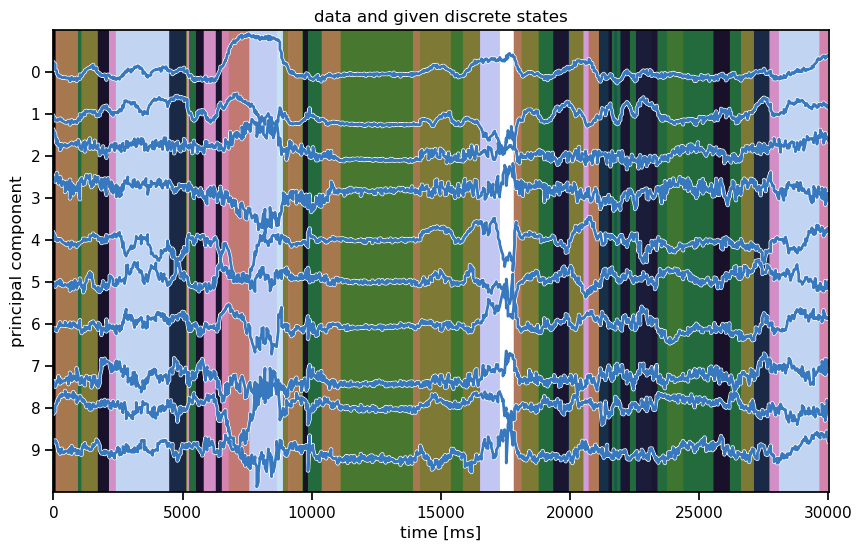

In [25]:
plot_data_and_states(train_dataset[0], train_dataset[0]["labels"],
                     title="data and given discrete states")

You should now have a `train_dataset` and a `test_dataset` loaded in memory. Each dataset is a list of dictionaries, one for each mouse. Each dictionary contains a few keys, most important of which is the data key, containing the standardized principal component time series, as shown above. For the test dataset, we also included the frames key, which has the original 80x80 images. We’ll use these to create the movies of each inferred state.

## 2. Forward-Backward Algorithm for HMMs
<!-- First, implement the forward-backward algorithm for computing the posterior distribution on latent states of a hidden Markov model, $ q(\mathbf{z}) = p(\mathbf{z} \mid \mathbf{x}, \Theta) $. Specifically, this algorithm will return a $ T \times K $ matrix where each entry represents the posterior probability that $ q(z_t = k) $. -->
The forward-backward algorithm is a key component in inference for Hidden Markov Models (HMMs). It is used to compute the posterior distribution over the latent (hidden) states given a sequence of observed data. This process allows us to answer the question: "What is the probability of the hidden state at a particular time given all the observed data?"

***(1) Objective***

Given an HMM, our goal is to compute the posterior distribution over the latent states,
$ q(\mathbf{z}) = p(\mathbf{z} \mid \mathbf{x}, \Theta) $,
where:
- $ \mathbf{z} = \{z_1, z_2, \ldots, z_T\} $ are the hidden state variables over time $ T $,
- $ \mathbf{x} = \{x_1, x_2, \ldots, x_T\} $ are the observed data over time $ T $,
- $ \Theta $ represents the parameters of the model, including the transition probabilities between states and the emission probabilities of the observations.

The forward-backward algorithm leverages the structure of HMMs to efficiently compute the posterior distribution. Specifically, it returns a $ T \times K $ matrix, where:
- $ T $ is the number of time steps in the sequence.
- $ K $ is the number of possible hidden states.

Each entry of this matrix, $ q(z_t = k) $, represents the posterior probability that the hidden state at time $ t $ is $ k $, given all the observed data $ \mathbf{x} $, which is $p(z_t = k | \mathbf{x})$.

***(2) Forward and Backward Passes***

The forward-backward algorithm works by breaking down the problem into two main passes:

1. **The Forward Pass:**
   - The forward pass computes the probability of the observed sequence up to time $ t $ and the hidden state at time $ t $,

     $ \alpha_t(k) = p(x_1, x_2, \ldots, x_t, z_t = k \mid \Theta) $.
   - It is calculated iteratively starting from $ t = 1 $ to $ T $, using the initial state distribution and transition probabilities.
   - This helps in computing the likelihood of being in a particular hidden state at a specific time step based on observations up to that point.

2. **The Backward Pass:**
   - The backward pass computes the probability of observing the sequence from time $ t+1 $ to $ T $, given the hidden state at time $ t $,

     $ \beta_t(k) = p(x_{t+1}, x_{t+2}, \ldots, x_T \mid z_t = k, \Theta) $.
   - It is calculated iteratively from $ t = T $ down to $ t = 1 $, and provides the likelihood of the remaining observations given a particular hidden state.

***(3) Computing the Posterior Distribution***

The posterior probability of being in state $ k $ at time $ t $, $ q(z_t = k) $, is computed as:

$$
\begin{align*}
q(z_t = k) = \frac{\alpha_t(k) \beta_t(k)}{\sum_{k'} \alpha_t(k') \beta_t(k')},
\end{align*}
$$


which combines the results from both the forward and backward passes.

***(4) Steps to Implement the Forward-Backward Algorithm***

To implement the forward-backward algorithm, follow these steps:

(a). **Initialization:**
   - Define the model parameters $ \Theta $: the initial state probabilities, transition matrix between states, and emission probabilities of observations given states.
   - Initialize the forward and backward matrices, $ \alpha $ and $ \beta $, with dimensions $ T \times K $.

(b). **Forward Pass Iteration:**
   - For $ t = 1 $, initialize $ \alpha_1(k) $ using the initial state distribution and the emission probabilities.
   - For each subsequent time step $ t $, update $ \alpha_t(k) $ based on the transition probabilities and the emission probabilities.

(c). **Backward Pass Iteration:**
   - Initialize $ \beta_T(k) = 1 $ for all states $ k $.
   - For each preceding time step $ t $, update $ \beta_t(k) $ based on the transition probabilities and the emission probabilities.

(d). **Compute Posterior Probabilities:**
   - Calculate $ q(z_t = k) $ for all $ t $ and $ k $ using the equation above.


### 2.1 Implement the forward pass (3 Points)
`Notes`:
- This function takes in the _log_ likelihoods, $\log \ell_{tk}$, so you'll have to exponentiate in the forward pass;
- You need to be careful exponentiating though. If the log likelihoods are very negative, they'll all be essentially zero when exponentiated and you'll run into a divide-by-zero error when you compute the forward message $\alpha_t$. Alternatively, if they're large positive numbers, your exponent will blow up and you'll get nan's in your calculations;
- To avoid numerical issues, subtract $\max_k (\log \ell_{tk})$ prior to exponentiating. It won't affect the forward messages, but you will have to account for it in your computation of the marginal likelihood.
- Also note to normalize the forward messages  $\alpha_t$ to avoid potential numerical issues. As the forward algorithm proceeds, $ \alpha_t(k) $ values are repeatedly multiplied by probabilities (transition and observation probabilities), many of which are less than 1. This causes $ \alpha_t(k) $ values to decrease exponentially over time. For long sequences, these values can become extremely small, potentially approaching zero. This phenomenon is known as *underflow*. We need to avoid this situation via normalizing.


In [11]:
def normalize(u, axis=0, eps=1e-15):
    """Normalizes the values within the axis in a way that they sum up to 1.

    Args:
        u: Input tensor to normalize.
        axis: Axis over which to normalize.
        eps: Minimum value threshold for numerical stability.

    Returns:
        Tuple of the normalized tensor, and the normalizing denominator.
    """
    u = torch.where(u == 0, torch.tensor(0.0, device=u.device),
                    torch.where(u < eps, torch.tensor(eps, device=u.device), u))
    c = u.sum(dim=axis)
    c = torch.where(c == 0, torch.tensor(1.0, device=u.device), c)
    u_normalized = u / c.unsqueeze(axis)
    return u_normalized, c

In [12]:
def forward_pass(initial_dist, transition_matrix, log_likes):
    """
    Perform the (normalized) forward pass of the HMM.

    Parameters
    ----------
    initial_dist: π, the initial state distribution. Length K, sums to 1.
    transition_matrix: P, a KxK transition matrix. Rows sum to 1.
    log_likes: log ℓ_{t,k}, a TxK matrix of _log_ likelihoods.

    Returns
    -------
    alphas: TxK matrix with _normalized_ forward messages α̃_{t,k}
    marginal_ll: Scalar marginal log likelihood log p(x | Θ)
    """
    T, K = log_likes.shape                  # get the number of time steps and states
    alphas = torch.zeros_like(log_likes)    # store normalized forward messages
    marginal_ll = 0.0

    # Step 1: get the likelihood of observation at the first itme step
    log_ell_t = log_likes[0]
    max_log_ell_t = torch.max(log_ell_t)
    log_ell_t_centered = log_ell_t - max_log_ell_t
    ell_t = torch.exp(log_ell_t_centered)

    # Step 2: get the normaized alpha values for the first time step
    # P(x_0, z_0)
    alpha_t_unnormalized = ell_t * initial_dist
    # P(x_0)
    A_t = torch.sum(alpha_t_unnormalized)
    alpha_t, _ = normalize(alpha_t_unnormalized)
    alphas[0] = alpha_t
    # log(P(x_0) * P(x_0|z_0=k*))
    marginal_ll += torch.log(A_t) + max_log_ell_t

    # Step 3: Iterate over time steps t = 1 to T-1
    for t in range(1, T):
        # Step 3.1: get the likelihood of observation at the current time step
        # No more than 4 lines, similar as step 1
        # YOUR CODE HERE
        # P(x_0...x_t-1, z_0 ... z_t-1=k)
        log_ell_t = log_likes[t]
        max_log_ell_t = torch.max(log_ell_t)
        log_ell_t_centered = log_ell_t - max_log_ell_t
        ell_t = torch.exp(log_ell_t_centered)

        # Step 3.2: compute the intermediate forward probabilities for the current time step
        # by aggregating the contributions from all possible previous state
        # no more than 1 line, using torch.matmul(...)
        # sum_over_z_t-1(P(x_0...x_t-1, z_t-1=k) * P(z_t=k|z_t-1=k*)) = P(x_0...x_t-1, z_t=k)
        p_z_t_k_given_joint = torch.matmul(alphas[t - 1], transition_matrix)

        # Step 3.3: get the normaized alpha values for the current time step
        # no more than 5 lines, similar as step 2
        # YOUR CODE HERE
        # P(x_0...x_t, z_t=k) 
        alpha_t_unnormalized = ell_t * p_z_t_k_given_joint
        A_t = torch.sum(alpha_t_unnormalized)
        alpha_t, _ = normalize(alpha_t_unnormalized)
        alphas[t] = alpha_t
        marginal_ll += torch.log(A_t) + max_log_ell_t

    return alphas, marginal_ll

In [13]:
# test your implemented forward pass
def test_forward_pass(num_timesteps=100, num_states=10, offset=0):
    pi, P, log_likes = random_args(num_timesteps, num_states, offset=offset)

    # Call your code
    alphas, ll = forward_pass(pi, P, log_likes)
    assert torch.all(torch.isfinite(alphas))
    assert torch.allclose(alphas.sum(axis=1), torch.tensor(1.0))

    # Compare to Dynamax implementation.
    from dynamax.hidden_markov_model import hmm_filter
    pi_np = from_t(pi)
    P_np = from_t(P)
    log_likes_np = from_t(log_likes)

    post = hmm_filter(pi_np, P_np, log_likes_np)
    assert np.allclose(from_t(ll), post.marginal_loglik)
    print("pass")

test_forward_pass()
test_forward_pass(num_timesteps=10000, num_states=50, offset=-1000)

pass
pass


### 2.2 Implement the backward pass (2 Points)

Recursively compute the backward messages $\beta_t$. Again, remember to normalize the backward messages $\beta_t$ to avoid numerical issue, and be careful when you exponentiate the log likelihoods. The same trick of subtracting the max before exponentiating will work here too.

In [15]:
def backward_pass(transition_matrix, log_likes):
    """
    Perform the (normalized) backward pass of the HMM.

    Parameters
    ----------
    transition_matrix: P, a KxK transition matrix. Rows sum to 1.
    log_likes: log ℓ_{t,k}, a TxK matrix of _log_ likelihoods.

    Returns
    -------
    betas: TxK matrix with _normalized_ backward messages β̃_{t,k}
    """
    T, K = log_likes.shape                            # get the number of time steps and states
    betas = torch.zeros_like(log_likes)               # store the backward messages

    # Step 1: initialization
    backward_pred_probs = torch.ones(K, device=log_likes.device)
    backward_pred_probs = backward_pred_probs / backward_pred_probs.sum()

    # Step 2: Iterate over time steps t = T to 1
    for t in reversed(range(T)):
        # Step 2.1: store the current backward message
        # P(x_T|z_T-1 = k)
        betas[t] = backward_pred_probs

        # Step 2.2: Condition on emission at time t, being careful not to overflow.
        # no more than 4 lines, using normalize(...)
        # YOUR CODE HERE
        # P(x_T-1, x_T|z_T-1=k) = P(x_T|z_T-1=k) * P(x_T-1|z_T-1=k)
        log_ell_t = log_likes[t] # 1 x K
        max_log_ell_t = torch.max(log_ell_t)
        log_ell_t_centered = log_ell_t - max_log_ell_t
        ell_t, _ = normalize(torch.exp(log_ell_t_centered) * betas[t]) # 1 x K

        # Step 2.3: Predict the next state, being careful not to overflow.
        # no more than 2 lines, using torch.matmul(...) and normalize(...)
        # YOUR CODE HERE
        # P(x_T-1, x_T | z_T-2=k) = sum_over_z_T-1(P(x_T-1, x_T|z_T-1=k) * P(z_T-1=k|z_T-2=k*))
        backward_pred_probs = torch.matmul(ell_t, transition_matrix)
        backward_pred_probs, _ = normalize(backward_pred_probs)

    return betas


### 2.3 Implement the E-step via combining the forward-backward passes (1 Point)
Let us implement the E-step in this sub-section, where you need to compute the posterior probability $q(z_t = k)$ introduced previously. To compute them, combine the forward messages, backward messages, and the likelihoods, then normalize. Again, be careful when exponentiating the likelihoods.

In [16]:
def E_step(initial_dist, transition_matrix, log_likes):
    """
    Run the forward and backward passes and then combine to compute the
    posterior probabilities q(z_t=k).

    Parameters
    ----------
    initial_dist: torch.Tensor
        Initial state distribution (length K).
    transition_matrix: torch.Tensor
        A KxK transition matrix (rows sum to 1).
    log_likes: torch.Tensor
        A TxK matrix of log likelihoods.

    Returns
    -------
    posterior: dict
        Dictionary containing:
        - posterior_prob: TxK matrix of posterior state probabilities.
        - marginal_ll: Scalar marginal log likelihood.
    """
    # Step 1: Run forward pass to compute alphas and marginal log likelihood
    alphas, marginal_ll = forward_pass(initial_dist, transition_matrix, log_likes)

    # Step 2: Run backward pass to compute betas
    # no more than one line, using predefined backward_pass()
    # YOUR CODE HERE
    betas = backward_pass(transition_matrix, log_likes)

    # Step 3: Combine forward and backward messages to compute posterior probability
    # no more than three lines, remember to do normalization
    posterior_prob = None
    # YOUR CODE HERE
    posterior_prob = alphas * betas
    posterior_prob, _ = normalize(posterior_prob, axis=1)
    
    # Package the results into a dictionary summarizing the posterior
    posterior = dict(posterior_prob=posterior_prob,
                     marginal_ll=marginal_ll)

    return posterior


In [17]:
# test your own implementation
def test_E_step(num_timesteps=100, num_states=10, offset=0):
    pi, P, log_likes = random_args(num_timesteps, num_states, offset=offset)

    # Run your code
    posterior = E_step(pi, P, log_likes)

    # Run Dynamax code
    from dynamax.hidden_markov_model import hmm_two_filter_smoother
    pi_np = from_t(pi)
    P_np = from_t(P)
    log_likes_np = from_t(log_likes)
    post = hmm_two_filter_smoother(pi_np, P_np, log_likes_np)

    assert np.allclose(posterior["posterior_prob"], post.smoothed_probs)
    assert np.allclose(posterior["marginal_ll"], post.marginal_loglik)
    print("pass")

test_E_step()
test_E_step(num_timesteps=10000, num_states=50, offset=-1000)

pass
pass


## 3. Gaussian Hidden Markov Models

In this section, we will implement a Hidden Markov Model (HMM) with Gaussian observations. The model can be expressed mathematically as:
$$
\begin{align}
p(x, z \mid \Theta) &= \mathrm{Cat}(z_1 \mid \pi) \prod_{t=2}^{T} \mathrm{Cat}(z_t \mid P_{z_{t-1}}) \prod_{t=1}^T \mathcal{N}(x_t \mid b_{z_t}, Q_{z_t})
\end{align}
$$
where the parameters are $\Theta = \{\pi, P, \{b_k, Q_k\}_{k=1}^K\}$. Here:
- $ x_t \in \mathbb{R}^{D} $ represents the observed data at time $ t $,
- $ z_t \in \{1, \ldots, K\} $ denotes the latent state at time $ t $,
- $ \pi $ is the initial state distribution,
- $ P $ is the transition matrix for the latent states,
- $ \mathcal{N}(x_t \mid b_{z_t}, Q_{z_t}) $ represents the Gaussian distribution with mean $ b_{z_t} $ and covariance matrix $ Q_{z_t} $.
### Maximization Step (M-step) for EM Algorithm
To update the parameters of the Gaussian HMM using the Expectation-Maximization (EM) algorithm, we work with the Evidence Lower Bound (ELBO). Because in this lab, we will only learn the parameters in the Gaussian observations, that is $b$ and $Q$, not $\pi$ and $P$, the ELBO in terms of $ b $ and $ Q $ is given as:
$$
\begin{align}
\mathcal{L}(q, \Theta) = \mathbb{E}_{q(z)} \left[ \sum_{t=1}^T \mathbb{I}[z_t = k] \cdot \log \mathcal{N}(x_t \mid b_{z_t}, Q_{z_t}) \right] + c,
\end{align}
$$
Here, $\mathbb{I}$ is the indicator function $$\mathbb{I}[\text{condition}] = 
\begin{cases} 
1 & \text{if the condition is true} \\
0 & \text{if the condition is false}
\end{cases}$$ and $ c $ encompasses all other terms in the ELBO that involve the categorical distributions. Explicitly:
$$
c = \mathbb{E}_{q(z)} \left[ \log \mathrm{Cat}(z_1 \mid \pi) + \sum_{t=2}^{T} \log \mathrm{Cat}(z_t \mid P_{z_{t-1}}) \right]
$$
Because the above $c$ expression does not include $b$ and $Q$, we just simplify them as a constant. Then, expanding $\mathcal{L}(q, \Theta)$ and taking the expectation, we have:
$$
\begin{align}
\mathcal{L}(q, \Theta) = \sum_{t=1}^T \sum_{k=1}^K q(z_t = k) \left( -\frac{D}{2} \log(2\pi) - \frac{1}{2} \log|Q_k| - \frac{1}{2}(x_t - b_k)^\top Q_k^{-1}(x_t - b_k) \right) + c,
\end{align}
$$
where:
- $ q(z_t = k) $ is the probability that the latent state $ z_t $ equals $ k $ at time $ t $,
- $ D $ is the dimensionality of the observation data $ x $.
To find the updated parameters, we take the gradients of $ \mathcal{L}(q, \Theta) $ with respect to $ b $ and $ Q $ and set them to zero. The updated mean and covariance expressions are:
$$
\begin{align}
b_k^{\text{new}} = \frac{t_{k,1}}{N_k},
\end{align}
$$
$$
\begin{align}
Q_k^{\text{new}} = \frac{t_{k,2}}{N_k} - b_k^{\text{new}} {b_k^{\text{new}}}^\top + \epsilon I,
\end{align}
$$
where:
- $ N_k = \sum_{t=1}^T q(z_t = k) $ is the total expected count of state $ k $,
- $ t_{k,1} = \sum_{t=1}^T q(z_t = k) x_t $ is the weighted sum of observations for state $ k $,
- $ t_{k,2} = \sum_{t=1}^T q(z_t = k) x_t x_t^\top $ is the weighted sum of outer products for state $ k $,
- $x_t$ and $ x_t x_t^\top $ are the sufficient statistics because they contain all the information necessary to estimate the parameters $ b_k $ and $ Q_k $ of the Gaussian distributions,
- $ \epsilon I $ is added to ensure the positive definiteness of the covariance matrix.

Since the dataset contains multiple trajectories, each representing a different mouse, we must aggregate information across all trajectories when computing $N_k$, $t_{k,1}$, $t_{k,2}$. Let $ M $ denote the number of mice in the dataset, and let $ x_t^{(m)} $ and $ z_t^{(m)} $ denote the observation and latent state at time $ t $ for mouse $ m $, respectively. The aggregated expressions are:
$$
\begin{align}
\bar{N}_k = \sum_{m=1}^{M} \sum_{t=1}^{T_m} q(z_t^{(m)} = k),
\end{align}
$$
$$
\begin{align}
\bar{t}_{k,1} = \sum_{m=1}^{M} \sum_{t=1}^{T_m} q(z_t^{(m)} = k) x_t^{(m)},
\end{align}
$$
$$
\begin{align}
\bar{t}_{k,2} = \sum_{m=1}^{M} \sum_{t=1}^{T_m} q(z_t^{(m)} = k) x_t^{(m)} x_t^{(m)\top}.
\end{align}
$$


Note that $\bar{N}_k$, $\bar{t}_{k,1}$, $\bar{t}_{k,2}$ are called expected sufficient statistics. We will now implement the computation of $\bar{N}_k$, $\bar{t}_{k,1}$, $\bar{t}_{k,2}$ and perform the M-step for Gaussian HMMs.

### 3.1 Implement the Computation of $\bar{N}_k$, $\bar{t}_{k,1}$, $\bar{t}_{k,2}$ (1.5 Points)

In this sub-section, you need to implement a function to compute the tuple of $\bar{N}_k$, $\bar{t}_{k,1}$, $\bar{t}_{k,2}$, then normalize them by the length of the sequence to avoid numerical issue. The above terms are combined across all mice (i.e., all the data dictionaries and posterior dictionaries).

In [18]:
def precompute_suff_stats(dataset):
    """
    Compute N_k, t_{k,1}, t_{k,2} of the Gaussian distribution for each
    data dictionary in the dataset. This modifies the dataset in place.

    Parameters
    ----------
    dataset: a list of data dictionaries.

    Returns
    -------
    Nothing, but the dataset is updated in place to have a new `suff_stats`
        key, which contains a tuple of N_k, t_{k,1}, t_{k,2}.
    """
    for data in dataset:
        x = data['data']
        data['suff_stats'] = (x,                                   # x_t
                              torch.einsum('ti,tj->tij', x, x))    # x_t x_t^T

In [26]:
precompute_suff_stats(train_dataset)
precompute_suff_stats(test_dataset)

In [27]:
def compute_expected_suff_stats(dataset, posteriors):
    """
    Compute a tuple of normalized N_k, t_{k,1}, t_{k,2} via dividing them by the
    length of the sequence. They are combined across all mice (i.e., all the data
    dictionaries and posterior dictionaries).

    Parameters
    ----------
    dataset: a list of dictionaries with multiple keys, including "data", the TxD
        array of observations for this mouse, and "suff_stats", the tuple of
        t_{k,1}, t_{k,2}.
        .
    posteriors: a list of dictionaries with the key "posterior_prob", which is
        a TxK array of posterior probabilities.

    Returns
    -------
    stats: a tuple of normalized N_k, t_{k,1}, t_{k,2}.
    """
    assert isinstance(dataset, list)
    assert isinstance(posteriors, list)

    # for a single time series and corresponding posterior.
    def _compute_expected_suff_stats(data, posterior):
        q = posterior['posterior_prob']
        suff_stats = data['suff_stats']
        t0 = suff_stats[0]
        t1 = suff_stats[1]

        T = t0.shape[0]  # Length of the sequence

        # step1: N for each state
        N = None
        # no more than one line, using tensor.sum(...)
        # YOUR CODE HERE
        N = q.sum(axis=0)

        # step2: t1 for each state
        t1s = None
        # no more than one line, using torch.einsum(...)
        # YOUR CODE HERE
        # q is TxK, t0 is x which is TxD t1s is KxD
        t1s = torch.einsum('tk,td->kd', q, t0)

        # step3: t1 for each state
        t2s = None
        # no more than one line, using torch.einsum(...)
        # YOUR CODE HERE
        t2s = torch.einsum('tk,tij->kij', q, t1)

        stats = (N, t1s, t2s)
        return T, stats

    # Initialize combined tuple of N_k, t_{k,1}, t_{k,2}
    combined_T = 0
    combined_stats = None

    # Sum the expected stats over the whole dataset
    for data, posterior in zip(dataset, posteriors):
        T, these_stats = _compute_expected_suff_stats(data, posterior)
        if combined_stats is None:
            combined_stats = these_stats
        else:
            # normalize by T
            combined_stats = tuple((cs + ts) / T for cs, ts in zip(combined_stats, these_stats))

    return combined_stats

### 3.2 Implement Maximization Process for Gaussian HMM (1 Point)

Please update the means and covariances in terms of the previous given expressions.

In [28]:
def M_step(num_states, data_dim, stats):
    """
    Compute the updated means and covariances of the Gaussian distribution
    Note: add a small amount (1e-4 * I) to the diagonal of each covariance
        matrix to ensure that the result is positive definite.

    Parameters
    ----------
    num_states: a scaler indicating the number of states
    data_dim: a scaler indicating the dimension of data
    stats: a tuple of N_k, t_{k,1}, t_{k,2}

    Returns
    -------
    updated means and covs
    """
    Ns, t1s, t2s = stats
    K = num_states
    D = data_dim

    ###
    # Update means
    # no more than one line
    means = None
    # YOUR CODE HERE
    means = t1s / Ns.unsqueeze(1)

    # Initialize covariance matrices
    covs = torch.zeros(K, D, D)

    # Update covariances for each state
    for k in range(K):
        # Ensure Ns[k] is greater than zero to avoid division by zero
        if Ns[k] > 0:
            # Update covariance
            # no more than four lines, remember to use torch.outer(...) and torch.eye(...)
            cov_k = None
            # YOUR CODE HERE
            cov_k = t2s[k] / Ns[k] - torch.outer(means[k], means[k]) + 1e-4 * torch.eye(D)

            covs[k] = cov_k
        else:
            # If Ns[k] equals to 0, use the identity matrix as the covariance
            covs[k] = torch.eye(D)

    return means, covs

### 3.3 Fit the Gaussian HMM with EM (1.5 Points)

In this section, you are going to implement a function to fit a Gaussian HMM with EM.

`Note`: This is only a partial fit, as this method will treat the initial state distribution and the transition matrix as fixed!

In [29]:
def get_log_likelihoods(num_states, means, covs, data):
    """
    Compute the matrix of log likelihoods of data for each state.

    Parameters
    ----------
    num_states: a scaler indicating the number of states
    means: a KxD array of means for each state
    covs: a KxDxD array of covariance matrices for each state
    data: a dictionary with multiple keys, including "data", the TxD array
        of observations.

    Returns
    -------
    log_likes: a TxK array of log likelihoods for each datapoint and
        discrete state.
    """
    x = data["data"]
    T = x.shape[0]
    K = num_states
    log_likes = torch.zeros(T, K)

    # Loop over each state to compute the log likelihoods
    for k in range(K):
        mvn = torch.distributions.MultivariateNormal(means[k], covs[k])
        log_likes[:, k] = mvn.log_prob(x)

    return log_likes

In [30]:
def fit(train_dataset,
        test_dataset,
        initial_dist,
        transition_matrix,
        num_states,
        data_dim,
        seed=0,
        num_iters=40):
    """
    Fit a Hidden Markov Model (HMM) with expectation maximization (EM).

    Note: This is only a partial fit, as this method will treat the initial
    state distribution and the transition matrix as fixed!

    Parameters
    ----------
    train_dataset: a list of dictionaries with multiple keys, including "targets",
        the TxD array of observations, "covariates", the TxP array of covariates,
        and "suff_stats", the tuple of N_k, t_{k,1}, t_{k,2}.

    test_dataset: as above but only used for tracking the test log likelihood
        during training.

    num_states: a scaler indicating the number of states.

    data_dim: a scaler indicating the dimension of data

    initial_dist: a length-K vector giving the initial state distribution.

    transition_matrix: a K x K matrix whose rows sum to 1.

    seed: random seed for initializing the algorithm.

    num_iters: number of EM iterations.

    Returns
    -------
    train_lls: array of likelihoods of training data over EM iterations
    test_lls: array of likelihoods of testing data over EM iterations
    posteriors: final list of posterior distributions for the training data
    test_posteriors: final list of posterior distributions for the test data
    """
    torch.manual_seed(seed)
    num_train = sum([len(data["data"]) for data in train_dataset])
    num_test = sum([len(data["data"]) for data in test_dataset])

    # Check the initial distribution and transition matrix
    assert initial_dist.shape == (num_states,) and \
        torch.all(initial_dist >= 0) and \
        torch.isclose(initial_dist.sum(), torch.tensor(1.0))
    assert transition_matrix.shape == (num_states, num_states) and \
        torch.all(transition_matrix >= 0) and \
        torch.allclose(transition_matrix.sum(axis=1), torch.tensor(1.0))

    # Initialize posterior and N_k, t_{k,1}, t_{k,2}
    posteriors = initialize_posteriors(train_dataset, num_states, seed=seed)
    stats = compute_expected_suff_stats(train_dataset, posteriors)

    train_lls = []
    test_lls = []

    for itr in trange(num_iters):
        # M step: update the parameters of the emission part in ELBO
        # one line code
        # YOUR CODE HERE
        means, covs = M_step(num_states, data_dim, stats)
        # E step: compute the posterior for each data dictionary in the dataset
        # using for loop to iterate over all training sampels
        # no more than 5 lines, using get_log_likelihoods, E_step
        # YOUR CODE HERE
        new_posteriors = []
        for data in train_dataset:
            log_likes = get_log_likelihoods(num_states, means, covs, data)
            new_posteriors.append(E_step(initial_dist, transition_matrix, log_likes))
        posteriors = new_posteriors

        # Compute the tuple of N_k, t_{k,1}, t_{k,2} under the new posteriors
        stats = compute_expected_suff_stats(train_dataset, posteriors)

        # Store the average train likelihood
        avg_train_ll = sum([p["marginal_ll"] for p in posteriors]) / num_train
        train_lls.append(avg_train_ll)

        # Compute the posteriors for the test dataset too
        # using for loop to iterate over all test sampels
        # no more than 5 lines, using get_log_likelihoods, E_step
        test_posteriors = None
        # YOUR CODE HERE
        test_posteriors = []    
        for data in test_dataset:
            log_likes = get_log_likelihoods(num_states, means, covs, data)
            test_posteriors.append(E_step(initial_dist, transition_matrix, log_likes))

        # Store the average test likelihood
        avg_test_ll = sum([p["marginal_ll"] for p in test_posteriors]) / num_test
        test_lls.append(avg_test_ll)

    train_lls = torch.tensor(train_lls)
    test_lls = torch.tensor(test_lls)
    return train_lls, test_lls, posteriors, test_posteriors


100%|██████████| 40/40 [03:46<00:00,  5.67s/it]


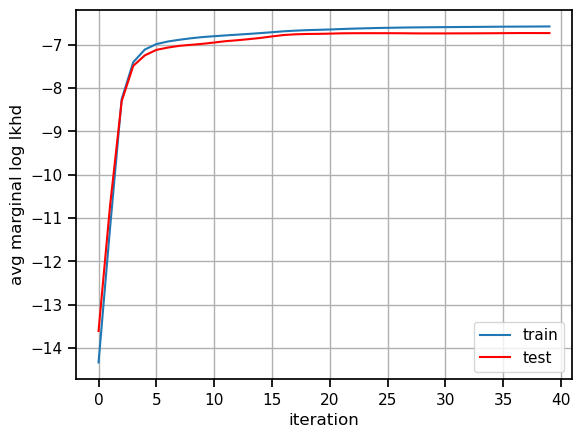

In [31]:
num_states = 50
initial_dist = torch.ones(num_states) / num_states
transition_matrix = sticky_transitions(num_states, stickiness=0.95)

# Fit it! It will take about 11 minutes.
train_lls, test_lls, train_posteriors, test_posteriors, = \
    fit(train_dataset[:1],
            test_dataset[:1],
            initial_dist,
            transition_matrix,
            num_states,
            data_dim)

plt.plot(train_lls, label="train")
plt.plot(test_lls, '-r', label="test")
plt.xlabel("iteration")
plt.ylabel("avg marginal log lkhd")
plt.grid(True)
plt.legend()

### 3.4 Plot the data and the inferred states


We'll make the same plot as above (in the warm-up) but using our inferred states instead. Hopefully, the states seem to switch along with changes in the data.

**Note**: We're showing the state with the highest marginal probability, $z_t^\star = \mathrm{arg} \, \mathrm{max}_k \; q(z_t = k)$. This is different from the most likely state path, $z_{1:T}^\star = \mathrm{arg}\,\mathrm{max} \; q(z)$. We could compute the latter with the Viterbi algorithm, which is similar to the forward-backward algorithm you implemented above.

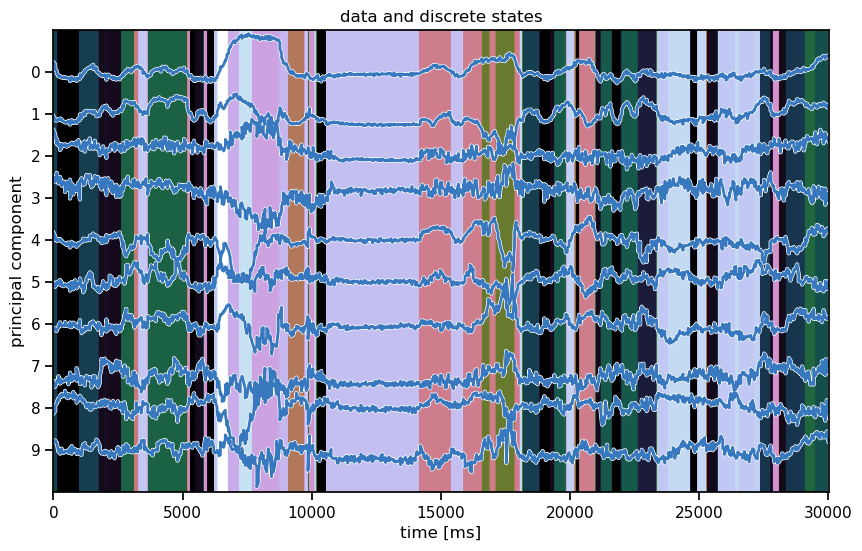

In [32]:
plot_data_and_states(train_dataset[0],
                     train_posteriors[0]["posterior_prob"].argmax(1))

### 3.5 Plot the state usage histogram


The state usage histogram shows how often each discrete state was used under the posterior distribution. You'll probably see a long tail of states with non-trivial usage (hundreds of frames), all the way out to state 50. That suggests the model is using all its available capacity, and we could probably crank the number of states up even further for this model.

Text(0.5, 1.0, 'histogram of inferred state usage')

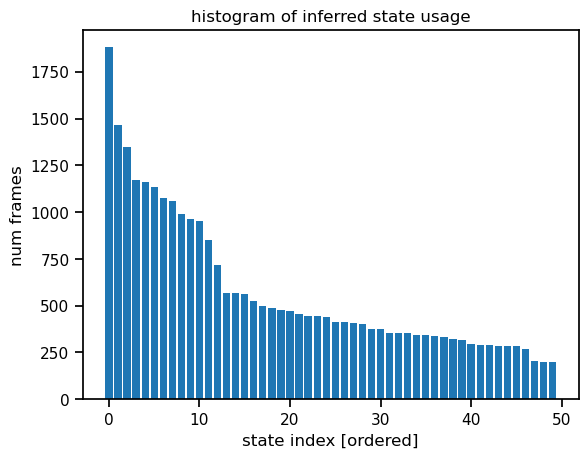

In [33]:
# Sort states by usage
ghmm_states = train_posteriors[0]["posterior_prob"].argmax(1)
ghmm_usage = torch.bincount(ghmm_states, minlength=num_states)
ghmm_order = torch.argsort(ghmm_usage, descending=True)

plt.bar(torch.arange(num_states), ghmm_usage[ghmm_order])
plt.xlabel("state index [ordered]")
plt.ylabel("num frames")
plt.title("histogram of inferred state usage")

### 3.6 Plot the average PC trajectory time locked to state entry

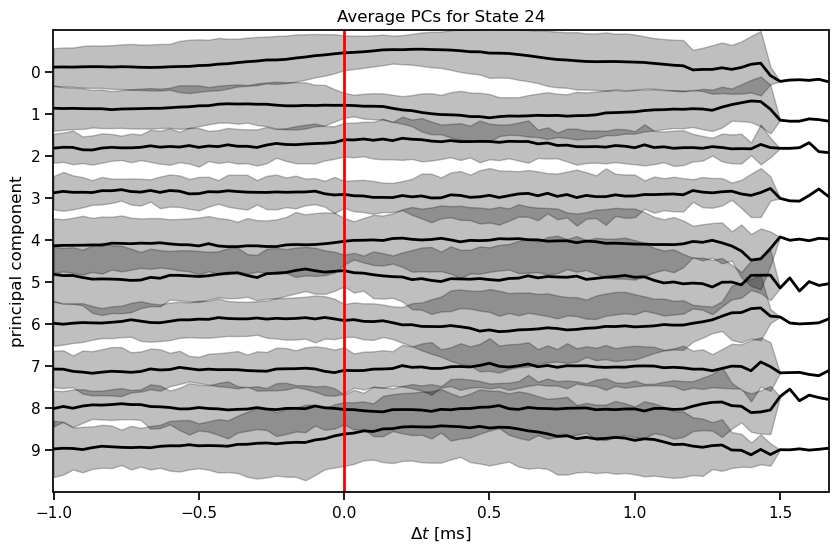

In [34]:
plot_average_pcs(ghmm_order[34], train_dataset[:1], train_posteriors[:1])

### 3.7 Plot some "crowd" movies

In [35]:
play(make_crowd_movie(ghmm_order[0], test_dataset, test_posteriors))

Preparing animation. This may take a minute...


In [36]:
play(make_crowd_movie(ghmm_order[1], test_dataset, test_posteriors))

Preparing animation. This may take a minute...


In [37]:
play(make_crowd_movie(ghmm_order[2], test_dataset, test_posteriors))

Preparing animation. This may take a minute...


In [38]:
play(make_crowd_movie(ghmm_order[30], test_dataset, test_posteriors))

Preparing animation. This may take a minute...
